In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval

# Cargar Data

In [2]:
path='../SOURCES/' 
path_out='%sCorpus2.csv' %(path)
data = pd.read_csv(path_out, sep=",", header=0, converters={"Corpus": literal_eval})
data.head()

,Clientes,Corpus
0,+++g8j9k+5A=,"[SinActividad, SinActividad, SinActividad, Sin..."
1,++/oQ9Lb9dI=,"[SinActividad, SinActividad, SinActividad, Sin..."
2,++14g8obpj0=,"[SinActividad, SinActividad, SinActividad, Sin..."
3,++1XMtcwMec=,"[SinActividad, SinActividad, SinActividad, Sin..."
4,++3gxZFOJCM=,"[cluster_30, SinActividad, SinActividad, SinAc..."


In [3]:
clientes = data["Clientes"].values

In [4]:
corpus = list(data["Corpus"])

# Sequitur para inferir reglas gramaticales

Aplicamos el algoritmo de sequitur para inferir las reglas gramaticales dado por los codigos de los comportamientos, que nos generara "reglas", definida por los simbolos que se repiten en la secuencia.


### Funciones de Apoyo

#### Otras Funciones

In [5]:
# Verifica que los elementos de una lista esten contenidos en otra lista
def elementos_en_lista(lista1, lista2):
    for i in range(len(lista1)):
        if not(lista1[i] in lista2):
            return False    
    return True

#### Algoritmo de Sequitur

In [6]:
from SequiturAlgorithm import run_sequitur

#### Descompresion de Sequitur

In [7]:
# Retorma la logintud de cada regla extendida y la regla estendida
def descomprimir_sequitur(semilla_l,nom_reglas,rs_comprimida,rs_tamaño,rs_extendida):
    num_reglas = len(nom_reglas)
    simbolos_semilla_les = [str(element) for element in list(np.unique(semilla_l))]
    simbolos_derivados = []
    
    incompleto = True
    contador = 0
    
    # 1 prueba: valores on solo 2 elementos
    for i in range(num_reglas):
        if elementos_en_lista(rs_comprimida[i],simbolos_semilla_les):
            rs_extendida[i] = rs_comprimida[i]
            rs_tamaño[i] =  len(rs_extendida[i]) # = 2
            simbolos_derivados.append(nom_reglas[i])  # cargamos la lista de reglas extendidas ya reconstruidas

    while(incompleto):
        # 2 pruebas: iterativas de 2 mas elementos
        for i in range(num_reglas):
            # si su profundidad aun no esta completada
            if rs_tamaño[i]==0:
                # si sus e estan entre los simbolos ya registrados
                if elementos_en_lista(rs_comprimida[i],(simbolos_semilla_les+simbolos_derivados)):
                    # para cada elemento de la lista
                    for e in range(len(rs_comprimida[i])):
                        if rs_comprimida[i][e] in simbolos_semilla_les:
                            rs_extendida[i].append(rs_comprimida[i][e])
                        if rs_comprimida[i][e] in simbolos_derivados:
                            indice = nom_reglas.index(rs_comprimida[i][e])
                            rs_extendida[i] =  rs_extendida[i] + rs_extendida[indice]
                    rs_tamaño[i] =  len(rs_extendida[i])  # actualizamos valor de prifundidad
                    simbolos_derivados.append(nom_reglas[i])  # cargamos la lista de reglas extendida
        
        # 3 Comprobamos que todas las reglas esten llenas
        if not(0 in rs_tamaño):
            incompleto = False

    return rs_tamaño,rs_extendida

### Funcion Principal

In [8]:
def generador_de_reglas(lista_original):
    # Ejecutamos Sequitur
    resp_sequitur = run_sequitur(lista_original)
    reglas = resp_sequitur[0]  # Extraemos solo la lista de reglas (Ver Alg. Sequitur)
    incidencia = resp_sequitur[1]
    
    # Creamos listas para cada regla: nombres,exp comprimidad, numero_incidencias, longitud, exp extendida
    r_nombre = []
    r_comprimida = []
    r_incidencias = []
    r_longitud = []
    r_extendida = []

    for i in range(len(reglas)):
        nombre = 'R'+str(i) 
        profundidad = 0
        # print(nombre,' -> ',reglas[nombre],"  =  ",profundidad)
        r_nombre.append(nombre)
        r_comprimida.append(reglas[nombre])
        r_incidencias.append(int(incidencia[nombre]))  # lista de incidencias
        r_longitud.append(profundidad)    # Inicialmente cargamos con "0"
        r_extendida.append([])               # Inicialmente cargamos con listas vacias

    # Descomprimimos reglas
    resultado = descomprimir_sequitur(lista_original,r_nombre,r_comprimida,r_longitud,r_extendida)

    if len(lista_original)!=len(resultado[1][0]):
        return "Error"

    r_longitud = resultado[0]
    r_extendida = resultado[1]

    return r_nombre, r_comprimida, r_incidencias, r_longitud, r_extendida
    #return r_incidencias,incidencia
    

#### Ejemplo

In [9]:
ejemplo = ["a","a","b","c","a","a","c","b","c"]
generador_de_reglas(ejemplo)

(['R0', 'R1', 'R2'],
 [['R1', 'R2', 'R1', 'c', 'R2'], ['a', 'a'], ['b', 'c']],
 [0, 2, 2],
 [9, 2, 2],
 [['a', 'a', 'b', 'c', 'a', 'a', 'c', 'b', 'c'], ['a', 'a'], ['b', 'c']])

# Validacion de Reglas de Cada Cliente

Aplicamos el algoritmo de sequitur para inferir las reglas gramaticales dado por los codigos de los comportamientos, que nos generara "reglas", definida por los simbolos que se repiten en la secuencia.


### Funciones de Apoyo

#### Generador de sequencias aleatorias

In [10]:
#ejemplo = corpus[1]

In [12]:
from random import choice

def random_sequence(seq_original):
    # Fixing random state for reproducibility
    np.random.seed(19680801)
    
    tags = list(np.unique(seq_original))        # Etiquetas de unicas
    long = len(seq_original)                    # Numero de perfiles unicos del cliente
    elementos = {tag:0 for tag in tags}         # Generamos lista aleatoria
    for i in range(len(seq_original)):    
        simbolo = ejemplo[i]
        elementos[simbolo] += 1

    sequences = []

    for i in range(long):
        simbolo_aleatorio = choice(tags)        # Generamos simbolo aleatorio
        elementos[simbolo_aleatorio] -= 1
        if elementos[simbolo_aleatorio] == 0:
            tags.remove(simbolo_aleatorio)
        sequences.append(simbolo_aleatorio)

    return sequences

In [13]:
random_sequence(ejemplo)

['c', 'b', 'b', 'c', 'c', 'a', 'a', 'a', 'a']

#### Informacion de la Regla Original

    #-------------------------------------------#
    # POSICION      Reglas_originales[POSICION] #
    #-------------------------------------------#
    #    0              Nombres                 #
    #    1              Comprimidas             #
    #    2              Incidencias             #
    #    3              Longitud                #
    #    4              Extendido               #
    #-------------------------------------------#

In [14]:
# Datos de la lista Original

reglas_originales = generador_de_reglas(ejemplo)

reglas_originales_nombre = reglas_originales[0]
reglas_originales_comprimidas = reglas_originales[1]
reglas_originales_incidencias = reglas_originales[2]
reglas_originales_longitud = reglas_originales[3]
reglas_originales_extendido = reglas_originales[4]

#### Generador de Muestra para validar Reglas

In [15]:
# lista original,numeros
def crear_muestra_reglas(lista_original,num = 100):
    
    # Datos de la lista Original
    reglas_originales = generador_de_reglas(lista_original)
    reglas_originales_nombre = reglas_originales[0]
    reglas_originales_comprimidas = reglas_originales[1]
    reglas_originales_incidencias = reglas_originales[2]
    reglas_originales_longitud = reglas_originales[3]
    reglas_originales_extendido = reglas_originales[4]
    
    # Creamos dataframe (nombre_regla, numero_incidencias_en_cada_iteracion, numero_de_iteracion)
    matriz = [[], [], []]


    for i in range(num):                              # para *num* repeticiones
        
        sequencia_aleatoria = random_sequence(lista_original)                # Creamos la lista Aleatoria
        
        # Datos de la lista Aleatoria
        reglas_aleatorias = generador_de_reglas(sequencia_aleatoria)
        reglas_aleatorias_extendidas = reglas_aleatorias[4]  
        reglas_aleatorias_incidencias = reglas_aleatorias[2] 
        
        # Para cada regla de las regla_originales
        for j in range(len(reglas_originales_nombre)):
            
            # Para cada REGLA de las "reglas_originales"
            
            # Buscamos si "REGLA original" apareces entre las "reglas_aleatorias_extendidas" y extraemos su numero de incidencias
            numero_de_incidencia = 0
            for k in range(len(reglas_aleatorias_extendidas)):
                # Si la REGLA (reglas_aleatorias_extendidas) se encuentra en lista de "reglas_aleatorias_extendidas"
                if reglas_originales_extendido[j] == reglas_aleatorias_extendidas[k]:
                    #print(True)
                    numero_de_incidencia = int(reglas_aleatorias_incidencias[k])
        
            # Cargamos fila de la lista Matriz
            matriz[0].append(reglas_originales_nombre[j])   # Guardamos nombre en la lista                
            matriz[1].append(numero_de_incidencia)          # Guardamos numero de iteracion
            matriz[2].append(i)                             # Guardamos numero de iteracion
    
    return matriz
            
            

## Grafico para cada Cliente

In [22]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math


    Para cada cliente
        
        Obtener lista de Reglas y DAtos
        Obtener muestra a validar (Muestra)
        
        Para cada Regla de la Muestra
            imprimir tabla agrupada por numero de incidencias
            plotear

In [70]:
# Clientes - Coordenada_X - Coordenada_Y - Longitud - Regla_extendida
resultados_list = [[],[],[],[],[]]

for i in range(len(clientes)):
    
    ejemplo = corpus[i]
    # Datos de la regla
    reglas_originales = generador_de_reglas(ejemplo)
    reglas_originales_nombre = reglas_originales[0]
    reglas_originales_comprimidas = reglas_originales[1]
    reglas_originales_incidencias = reglas_originales[2]
    reglas_originales_longitud = reglas_originales[3]
    reglas_originales_extendido = reglas_originales[4]


    print("Cliente: ",i)
    # Creamos dataframe (nombre_regla, numero_incidencias_en_cada_iteracion, numero_de_iteracion)
    m = crear_muestra_reglas(ejemplo,1000)
    muestra = pd.DataFrame(data= {'Nombre': m[0], 'Incidencias': m[1], 'Iteracion': m[2]})
    #print(muestra.head(10))
    
    # Para cada Regla
    for j in range(len(reglas_originales_nombre)):
        #print("Regla: ",j,"       ==> ",reglas_originales_extendido)
        #print("Regla: ",reglas_originales_nombre[j])
        
        # Muestra de solo un aregla y distribucion de una regla
        submuestra = muestra.loc[muestra['Nombre'] == reglas_originales_nombre[j]]
        ditribucion = submuestra.groupby(['Incidencias']).count()      # Us por incidencias
        #print(ditribucion)
        
        xx = ditribucion["Nombre"].tolist()
        yy = ditribucion["Iteracion"].tolist()
        indices = [str(i) for i in list(ditribucion.index)]

        resultados_list[0].append(clientes[i])
        resultados_list[1].append(yy)
        resultados_list[2].append(indices)
        resultados_list[3].append(len(reglas_originales_extendido[j]))
        resultados_list[4].append(reglas_originales_extendido[j])
        
        #plt.bar(indices,yy)
        #plt.plot(indices,ditribucion)
        #plt.show()
    
    if i == 10:
        break;

Cliente:  0
Cliente:  1
Cliente:  2
Cliente:  3
Cliente:  4
Cliente:  5
Cliente:  6
Cliente:  7
Cliente:  8
Cliente:  9
Cliente:  10


In [66]:
# ejemplo = corpus[1]

len(resultados_list[0]),len(resultados_list[1]),len(resultados_list[4])

(75, 75, 75)

In [ ]:
# Ploteamos

In [72]:
for i in range(len(resultados_list[0])):
    print(i)
    # Clientes - Coordenada_X - Coordenada_Y - Longitud - Regla_extendida
    cliente = resultados_list[0][i]
    xx = resultados_list[1][i]
    yy = resultados_list[2][i]
    longitud = resultados_list[3][i]
    regla = resultados_list[4][i]
    # xx = ditribucion["Nombre"].tolist()
    yy = ditribucion["Iteracion"].tolist()
    indices = [str(i) for i in list(ditribucion.index)]

    plt.bar(indices,yy)
    plt.plot(indices,ditribucion)
    plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


In [ ]:
# xx = ditribucion["Nombre"].tolist()
yy = ditribucion["Iteracion"].tolist()
indices = [str(i) for i in list(ditribucion.index)]

plt.bar(indices,yy)
plt.plot(indices,ditribucion)
plt.show()

In [18]:
# Creamos dataframe (nombre_regla, numero_incidencias_en_cada_iteracion, numero_de_iteracion)

m = crear_muestra_reglas(ejemplo,1000)
muestra = pd.DataFrame(data= {'Nombre': m[0], 'Incidencias': m[1], 'Iteracion': m[2]})
print(muestra.head(10))

  Nombre  Incidencias  Iteracion
0     R0            0          0
1     R1            2          0
2     R2            0          0
3     R3            0          0
4     R4            2          0
5     R5            3          0
6     R0            0          1
7     R1            2          1
8     R2            0          1
9     R3            0          1


In [19]:
# Muestra de solo un aregla y distribucion de una regla

submuestra = muestra.loc[muestra['Nombre'] == 'R1']
ditribucion = submuestra.groupby(['Incidencias']).count()      # Us por incidencias
ditribucion

,Nombre,Iteracion
Incidencias,,
0,28,28
2,897,897
3,74,74
4,1,1


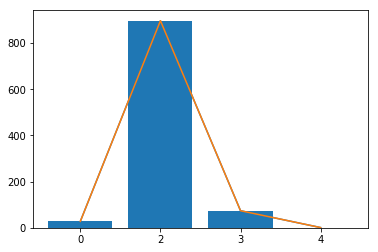

In [20]:
# xx = ditribucion["Nombre"].tolist()
yy = ditribucion["Iteracion"].tolist()
indices = [str(i) for i in list(ditribucion.index)]

plt.bar(indices,yy)
plt.plot(indices,ditribucion)
plt.show()

In [24]:
indices

['2', '3', '4']

In [ ]:
len(clientes)

In [ ]:
len(corpus)

In [ ]:
# Reglas validas
# Cliente  Regla ocurrencias
reglas_validas = [[], [], []]

for i in range(len(clientes)):
    # Extraer Reglas validad  == funcion get rules
    # para cada regla
    #    
    
        reglas_validas[0].append(clientes[i])
        reglas_validas[1].append(i)
        reglas_validas[2].append(i*i)

In [ ]:
reglas_validas

pd.DataFrame(data= {'Cliente':reglas_validas[0], 'Regla': reglas_validas[1], 'Incidencias': reglas_validas[2]})